## Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

# GLOBAL VARIABLES

# time horizon in years
T = 20  

# number of time steps
N = int(T * 252 * 7)  

# change remige's lenght
l_regime = int(0.5  * 252 * 7)

# time interval
dt = T / N

# GBM parameters
gbm_par = np.array(
    [[0.02, 0.2], #mu,sigma bull-regime
    [-0.02, 0.3]]) #mu,sigma bear-regime

# array of all the timesteps
timestep = np.linspace(0, T, N)

In [2]:
def data_par(h_1, h_2):
    '''
    Given the hyper parameters h_1 and h_2 it returns the number of sub-sequences M and the effective number of log-returns that
    are involved in the analysis N_prime.
    
    '''
    
    # check the number of possible sub sequences M
    i = 0
    # N - 2 (-1:from price to log-return and -1:becuase the last index is lenght of the array -1)
    while ((h_1 - h_2) * i + h_1) <= (N-2):
        i = i + 1

    # IMPORTANT parameters
    M = i 
    N_prime = (h_1 - h_2) * (M-1) + h_1 + 1
    
    return N_prime, M

h_1 = 35
h_2 = 28
N_prime, M = data_par(h_1, h_2)
t = timestep[: N_prime + 1]

print(f"price values not included in the analysis = {len(timestep) - len(t)}")

price values not included in the analysis = 5


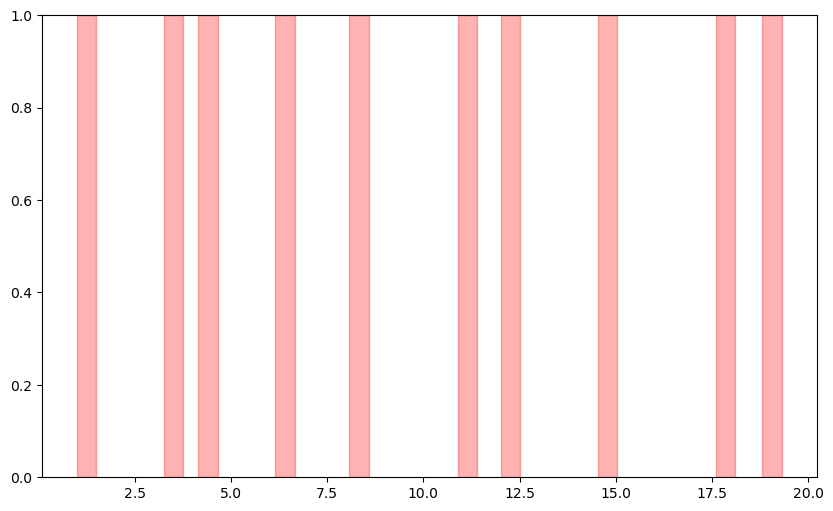

In [3]:
def generate_regimes(N_prime):
    '''
    It generates randomly 10 different time interval of the same same lenght.
    
    '''

    A = np.arange(0, N_prime+1)

    # Parametri delle sottosequenze
    num_subsequences = 10
    subseq_length = l_regime 

    # Set per memorizzare gli indici di partenza usati
    used_indices = set()

    # Funzione per generare un indice di partenza valido
    def generate_start_index(random_state=17):
        np.random.seed(random_state)
        while True:
            # Genera un indice di partenza casuale
            start_index = np.random.randint(0, len(A) - subseq_length - 1)
            # Controlla se l'indice di partenza e l'indice finale (con buffer di 1) sono validi
            if all((start_index + i) not in used_indices for i in range(subseq_length + 1)):
                for i in range(subseq_length + 1):
                    used_indices.add(start_index + i)
                return start_index

    # Generazione delle sottosequenze random non sovrapposte con almeno un elemento di distanza
    subsequences = []
    for _ in range(num_subsequences):
        start_index = generate_start_index()
        subsequences.append(A[start_index:start_index + subseq_length])

    subsequences = np.sort(np.array(subsequences), axis=0)
    
    # label for the log-returns
    B = np.zeros(N_prime)
    for sub in subsequences:
        B[sub[0]: sub[-1]] = 1    
    B = B.astype(int)

    # label for prices
    C = np.zeros(N_prime+1)
    for sub in subsequences:
        C[sub] = 1    
    C = C.astype(int)


    
    return subsequences, B, C

subsequences, theo_labels, labels_prices = generate_regimes(N_prime)

# plot of the regimes
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.axvspan(timestep[subsequences[i][0]], timestep[subsequences[i][-1]], color='red', alpha=0.3)
plt.show()

mean_path = 1.5904336169888507 
std_path = 0.8746807632129775


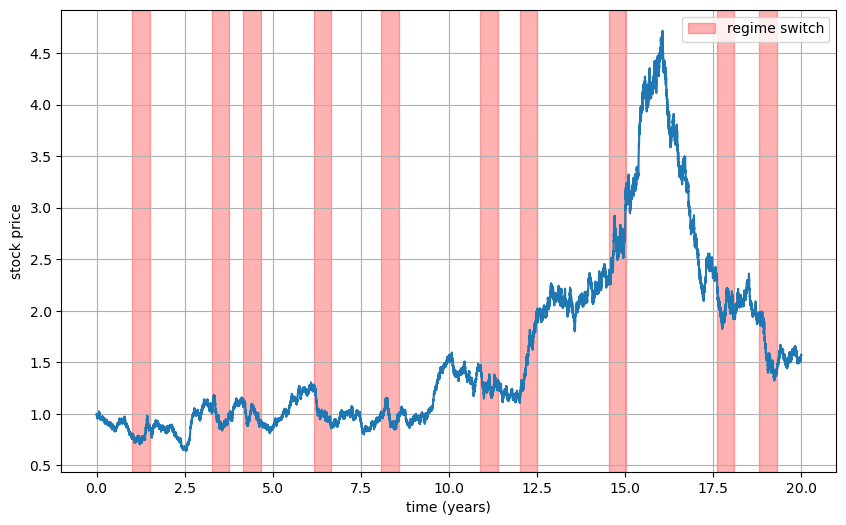

In [4]:
def gbm(S0, mu, sigma, n, dt):
    """
    Simulates a Geometric Brownian Motion (GBM).

    Parameters:
    S0 (float): Initial stock price
    mu (float): Drift coefficient
    sigma (float): Volatility coefficient
    T (float): Time horizon
    n (int): Number of time steps

    Returns:
    np.ndarray: Simulated stock prices

    """
    t = np.arange(1, n) * dt
    W = np.random.standard_normal(size=n-1) 
    W = np.cumsum(W) * np.sqrt(dt) # cumulative sum to simulate the Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = np.zeros(n)
    S[0] = S0
    S[1:] = S0 * np.exp(X)
    return S

def gbm_path(N_prime, C, t):
    
#     np.random.seed(17)
    '''
    It simulates the entire path of a GBM with regimes switch.
    
    '''
    # array of prices
    s = np.zeros(N_prime + 1)
    # initial stock price
    s[0] = 1
    s_0 = s[0]
    start_index = 0
    stop_index = 1

    for k in range(1, N_prime+1):
        if k == N_prime:
            s[start_index : stop_index + 1] = gbm(s_0, gbm_par[C[k]][0], gbm_par[C[k]][1], len(t[start_index : stop_index + 1]), dt)

        elif C[k] == C[k+1]:
            stop_index = k+1

        else:
            s[start_index : stop_index + 1] = gbm(s_0, gbm_par[C[k]][0], gbm_par[C[k]][1], len(t[start_index : stop_index + 1]), dt)
            #updates
            start_index = k
            s_0 = s[k]
            stop_index = k + 1
            
    return s

# to ensure reproducibility
np.random.seed(15)

# relevant time series
prices = gbm_path(N_prime, labels_prices, t)  
log_returns = np.diff(np.log(prices))

print(f'mean_path = {np.mean(prices)} \nstd_path = {np.std(prices)}')

# plot price path
plt.figure(figsize=(10, 6))
plt.plot(t,prices)
for i in range(10):
    if i == 0:
        plt.axvspan(t[subsequences[i][0]], t[subsequences[i][-1]], color='red', alpha=0.3, label='regime switch')
        
    else:
        plt.axvspan(t[subsequences[i][0]], t[subsequences[i][-1]], color='red', alpha=0.3)
        
    
#plt.title("Geometric Brownian Motion Simulation")
plt.xlabel("time (years)")
plt.ylabel("stock price")
plt.grid()
plt.legend()
plt.show()
plt.show()

In [5]:
def lift_function(h_1, h_2, log_returns, M):
    '''
    It returns a matrix (and the sorted version) in which the rows are the subsequences.
    
    '''

    # creation of the sub-sequences
    lift_matrix = np.ndarray((M, h_1 + 1))

    for j in range(0, M):
        lift_matrix[j] = log_returns[(h_1 - h_2) * j : (h_1 - h_2) * j + h_1 + 1]

    sorted_lift_matrix = np.sort(lift_matrix)
    return lift_matrix, sorted_lift_matrix

lift_matrix, sorted_lift_matrix = lift_function(h_1, h_2, log_returns, M)
print(f'number of sub sequences = {M}')

number of sub sequences = 5035


In [6]:
# costruction of a suitable dataset

# from each empiracal cdf we take the firsts q moments (a vector of dim. q for each empirical cdf)
q = 4

# Function to compute the k-th raw moment along a specified axis
def raw_moment_nd(values, k, axis=None):
    return np.mean(values**k, axis=axis)


# compute raw moments along the specified axis (axis=None computes the raw moments over the entire array)
X_moments = np.array([raw_moment_nd(lift_matrix, k, axis=1) for k in range(1, q+1)]).T

# initialize the StandardScaler
scaler = StandardScaler()

# fit and transform the data
standardized_X_moments = scaler.fit_transform(X_moments)

# print the standardized data
print(np.mean(standardized_X_moments, axis=0))
print(np.std(standardized_X_moments, axis=0))

[-4.23362107e-18  1.91924155e-16 -5.64482809e-18 -1.97568983e-17]
[1. 1. 1. 1.]


## MK-means

In [15]:
def euclidean_distance(a, b):
        """Calculate the Euclidean distance between two points."""
        return np.linalg.norm(a - b)

class MKMeans:
    
    def __init__(self, n_clusters=2, max_iter=600, tol=1e-8, random_state=None):
        
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)

        n_samples = X.shape[0]

        # Initialize cluster centers
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

        for i in range(self.max_iter):
            
            # Compute distances and assign clusters
            distances = pairwise_distances(X, self.cluster_centers_, metric=euclidean_distance)
            labels = np.argmin(distances, axis=1)

            # Compute new cluster centers
            new_centers = np.array([np.mean(X[labels == j] ,axis=0) for j in range(self.n_clusters)])
            
            # Check for convergence
            loss = 0
            for j in range(self.n_clusters):
                loss = loss + euclidean_distance(self.cluster_centers_[j], new_centers[j])
                
            if loss < self.tol:
                break

            self.cluster_centers_ = new_centers

        self.labels_ = labels
        return self

    def predict(self, X):
        distances = pairwise_distances(X, self.cluster_centers_, metric=euclidean_distance)
        return np.argmin(distances, axis=1)


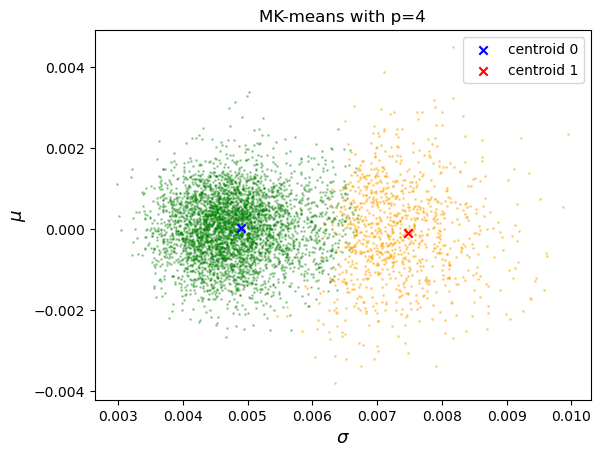

In [16]:
# Fit the  MK-means
mkmeans = MKMeans(random_state=1)
mkmeans.fit(standardized_X_moments)

# centroids in the real space
centroids = scaler.inverse_transform(mkmeans.cluster_centers_) 

# off-regime->lower variance
off_regime_index = 0 
# on-regime->higher variance
on_regime_index = 1 
# check regime
if (centroids[0][1] - (centroids[0][0])**2) > (centroids[1][1] - (centroids[1][0])**2):
    off_regime_index = 1
    on_regime_index = 0

# scatter plot of empirical cdf
point_size = 4
plt.scatter(
    np.std(lift_matrix[mkmeans.labels_ == off_regime_index], axis=1),
    np.mean(lift_matrix[mkmeans.labels_ == off_regime_index], axis=1),
    marker='.', color='green', alpha=0.3, s=point_size)
plt.scatter(
    np.std(lift_matrix[mkmeans.labels_ == on_regime_index], axis=1),
    np.mean(lift_matrix[mkmeans.labels_ == on_regime_index], axis=1),  
    marker='.', color='orange', alpha=0.4, s=point_size)

# scatter plot of centroids

plt.scatter(np.sqrt(centroids[off_regime_index][1] - (centroids[off_regime_index][0])**2),
            centroids[off_regime_index][0],
            color='blue', marker='x', label='centroid 0')
plt.scatter(np.sqrt(centroids[on_regime_index][1] - (centroids[on_regime_index][0])**2),
            centroids[on_regime_index][0],
            color='red', marker='x', label='centroid 1')

plt.xlabel(f'$\sigma$', size=13)
plt.ylabel(f'$\mu$', size=13)
plt.title(f'MK-means with p={q}')
plt.legend()
plt.show()

## Accuracy scores

In [9]:
def opt_counter(kmeans, n, M, h_1, h_2):


    # Define the time indices for the sliding window
    time_indices = np.arange(n)[:, None] - (h_1 - h_2) * np.arange(M)[None, :]

    # Mask invalid indices
    valid_mask = (time_indices >= 0) & (time_indices <= h_1)

    # Use the valid_mask to filter time indices
    filtered_time_indices = time_indices * valid_mask

    # Create the labels array, repeated across all k for efficient processing
    labels_repeated = np.tile(kmeans.labels_, (n, 1))

    # Use the valid mask to apply the labels where indices are valid
    filtered_labels = np.where(valid_mask, labels_repeated, -1)

    # Count occurrences of each label
    r_counter_0 = np.sum(filtered_labels == 0, axis=1)
    r_counter_1 = np.sum(filtered_labels == 1, axis=1)

    # Combine the counts into a single array
    r_counter = np.stack((r_counter_0, r_counter_1), axis=1)
    
    # Initialize s_counter with the same shape as r_counter
    s_counter = np.zeros((n+1, 2))

    # Handle the first element
    s_counter[0] = r_counter[0]

    # Handle the last element
    s_counter[-1] = r_counter[-1]

    # For all other elements, sum the current and previous elements
    s_counter[1:-1] = r_counter[:-1] + r_counter[1:]

    
    return r_counter, s_counter


In [10]:
%%time
r_counter, s_counter = opt_counter(mkmeans, len(log_returns), M, h_1, h_2)

dec = 2
# regime-off accuracy score (ROFS)
ROFS = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])
print(f'ROFS = {round(ROFS, dec)}')

# regime-off accuracy score (ROFS)
RONS = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])
print(f'RONS = {round(RONS, dec)}')

# total accuracy (TA)
TA = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
print(f'TA = {round(TA, dec)}')

ROFS = 0.99
RONS = 0.76
TA = 0.93
Wall time: 3.51 s


# CLUSTERING VALIDATION

In [23]:
def clustering_validation(h_1 = 35, h_2 = 28, n_runs = 50):
    
    rofs = np.zeros(n_runs)
    rons = np.zeros(n_runs)
    ta = np.zeros(n_runs)
    iteration_times = np.zeros(n_runs)
    
    N_prime, M = data_par(h_1, h_2)
    t = timestep[: N_prime + 1]
    subs, theo_labels, price_labels = generate_regimes(N_prime)
    
    for j in range(n_runs): 
        
        # data preparation
        np.random.seed(j)
        log_returns = np.diff(np.log(gbm_path(N_prime, price_labels, t)))
        # start timing
        start = time.time()
        lift_matrix = lift_function(h_1, h_2, log_returns, M)[0]
        ### IMPORTANT ##
        q = 4
        # 
        X_moments = np.array([raw_moment_nd(lift_matrix, k, axis=1) for k in range(1, q+1)]).T
        # initialize the StandardScaler
        scaler = StandardScaler()
        # fit and transform the data
        standardized_X_moments = scaler.fit_transform(X_moments)

        # clustering
        mkmeans = MKMeans()
        mkmeans.fit(standardized_X_moments)

        # centroids in the real space
        centroids = scaler.inverse_transform(mkmeans.cluster_centers_) 

        # off-regime->lower variance
        off_regime_index = 0 
        # on-regime->higher variance
        on_regime_index = 1 
        # check regime
        if (centroids[0][1] - (centroids[0][0])**2) > (centroids[1][1] - (centroids[1][0])**2):
            off_regime_index = 1
            on_regime_index = 0

        # counter    
        r_counter = opt_counter(mkmeans, len(log_returns), M, h_1, h_2)[0]

        # regime-off accuracy score (ROFS)
        rofs[j] = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])

        # regime-off accuracy score (ROFS)
        rons[j] = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])

        # total accuracy (TA)
        ta[j] = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
        
        iteration_times[j] = time.time() - start

    return rofs, rons, ta, iteration_times

In [24]:
%%time
dec = 4
rofs, rons, ta, iteration_times = clustering_validation(h_1 = 35, h_2 = 28, n_runs = 50)
print(f"ROFS = {round(np.mean(rofs), dec)} -+ {round(np.std(rofs), dec)}")
print(f"RONS = {round(np.mean(rons), dec)} -+ {round(np.std(rons), dec)}")
print(f"TA = {round(np.mean(ta), dec)} -+ {round(np.std(ta), dec)}")
print(f"RUN TIME = {round(np.mean(iteration_times), dec)} -+ {round(np.std(iteration_times), dec)}")

ROFS = 0.9942 -+ 0.0018
RONS = 0.7572 -+ 0.0316
TA = 0.935 -+ 0.0078
RUN TIME = 3.4473 -+ 0.3338
Wall time: 2min 53s


In [25]:
# print the results as txt file

df = pd.DataFrame({
    'ROFS': rofs,
    'RONS': rons,
    'TA': ta,
    'RUNTIME': iteration_times
})

# check the valuse of the parameters below! 
# REMINDER:
# p=2, wkmeans(w), h=h_1,h_2, path = gbm, seed of the clustering = 30, n_trials=50, max_ite = 600, tol=1e-8
# name of the file = 'numerical_results/2_w_35_28_gbm_15_n_50_ite_600_tol_8.txt'

df.to_csv('numerical_results/4_m_means_h_35_28_gbm_free_n_50_ite_600_tol_8.txt', index=False)

In [ ]:
# read the results
df = pd.read_csv('numerical_results/4_m_means_h_35_28_gbm_30_n_50_ite_600_tol_8.txt')

rofs = df['ROFS'].values
rons = df['RONS'].values
ta = df['TA'].values
iteration_times = df['RUNTIME'].values

print(f"ROFS = {round(np.mean(rofs), 2)} -+ {round(np.std(rofs), 2)}")
print(f"RONS = {round(np.mean(rons), 2)} -+ {round(np.std(rons), 2)}")
print(f"TA = {round(np.mean(ta), 2)} -+ {round(np.std(ta), 2)}")
print(f"RUN TIME = {round(np.mean(iteration_times), 2)} -+ {round(np.std(iteration_times), 2)}")

# dependences by the seed

In [35]:
# WARNING: run again if you change something in the section Data preparation !!!

def mk_means_function(random_seed):

    # Fit the  MK-means
    mkmeans = MKMeans(random_state=random_seed)
    mkmeans.fit(standardized_X_moments)

    # centroids in the real space
    centroids = scaler.inverse_transform(mkmeans.cluster_centers_) 

    # off-regime->lower variance
    off_regime_index = 0 
    # on-regime->higher variance
    on_regime_index = 1 
    # check regime
    if (centroids[0][1] - (centroids[0][0])**2) > (centroids[1][1] - (centroids[1][0])**2):
        off_regime_index = 1
        on_regime_index = 0
        
        
        
    r_counter, s_counter = opt_counter(mkmeans, len(log_returns), M, h_1, h_2)

    # regime-off accuracy score (ROFS)
    ROFS = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])

    # regime-off accuracy score (ROFS)
    RONS = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])

    # total accuracy (TA)
    TA = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
    
    return ROFS, RONS, TA


In [36]:
def convert_seconds(seconds):
    minutes = int(seconds // 60)
    remaining_seconds = seconds % 60
    return f"{minutes} min {int(remaining_seconds)} seconds"

In [57]:
n_trials = 50

rofs = np.zeros(n_trials)
rons = np.zeros(n_trials)
ta = np.zeros(n_trials)
iteration_times = np.zeros(n_trials)

start_time_tot = time.time()
for i in range(n_trials):
    # start
    start_time = time.time()
    # real computation
    rofs[i], rons[i], ta[i] = mk_means_function(i+1)
    # end
    end_time = time.time()
    # save data
    iteration_times[i] = end_time - start_time
end_time_tot = time.time()

input_seconds = float(end_time_tot - start_time_tot)
print(f'time to complete all the iterations = {convert_seconds(input_seconds)}')

print(f'ROFS = {np.mean(rofs)} +- {np.std(rofs)}')
# print(f'ROFS_max = {np.max(rofs)} \nROFS_min = {np.min(rofs)}')

print(f'\nRONS = {np.mean(rons)} +- {np.std(rons)}')
# print(f'RONS_max = {np.max(rons)} \nRONS_min = {np.min(rons)}')

print(f'\nTA = {np.mean(ta)} +- {np.std(ta)}')
# print(f'TA_max = {np.max(ta)} \nTA_min = {np.min(ta)}')

print(f'\nRUN TIME = {np.mean(iteration_times)} +- {np.std(iteration_times)} seconds')

time to complete all the iterations = 3 min 28 seconds
ROFS = 0.9888080264212842 +- 0.0003107967058830479

RONS = 0.8575311748217793 +- 0.0012843054840888728

TA = 0.9559931589981241 +- 0.0001073717838210419

RUN TIME = 4.161142792701721 +- 1.2509974260282448 seconds


In [58]:
# print the results as txt file

df = pd.DataFrame({
    'ROFS': rofs,
    'RONS': rons,
    'TA': ta,
    'RUNTIME': iteration_times
})

# check the valuse of the parameters below! 
# REMINDER:
# p=2, mk-means(m), accuracy scores, path = gbm, seed of the fixed path = 15, n_trials=50, max_ite = 300, tol=1e-4
# name of the file = 'numerical_results/2_m_accuracy_scores_gbm_15_n_50_ite_300_tol_4.txt'

df.to_csv('numerical_results_stability/2_m_accuracy_scores_gbm_15_n_50_ite_700_tol_8.txt', index=False)

In [41]:
# read the results
df = pd.read_csv('numerical_results_stability/2_m_accuracy_scores_gbm_15_n_50_ite_500_tol_6.txt')

rofs = df['ROFS'].values
rons = df['RONS'].values
ta = df['TA'].values
iteration_times = df['RUNTIME'].values

print(f'ROFS = {np.mean(rofs)} +- {np.std(rofs)}')
# print(f'ROFS_max = {np.max(rofs)} \nROFS_min = {np.min(rofs)}')

print(f'\nRONS = {np.mean(rons)} +- {np.std(rons)}')
# print(f'RONS_max = {np.max(rons)} \nRONS_min = {np.min(rons)}')

print(f'\nTA = {np.mean(ta)} +- {np.std(ta)}')
# print(f'TA_max = {np.max(ta)} \nTA_min = {np.min(ta)}')

print(f'\nRUN TIME = {np.mean(iteration_times)} +- {np.std(iteration_times)} seconds')

ROFS = 0.9888080264212842 +- 0.0003107967058830938

RONS = 0.8575311748217793 +- 0.0012843054840888728

TA = 0.9559931589981241 +- 0.00010737178382110726

RUN TIME = 4.0834802675247195 +- 1.2016297503487208 seconds


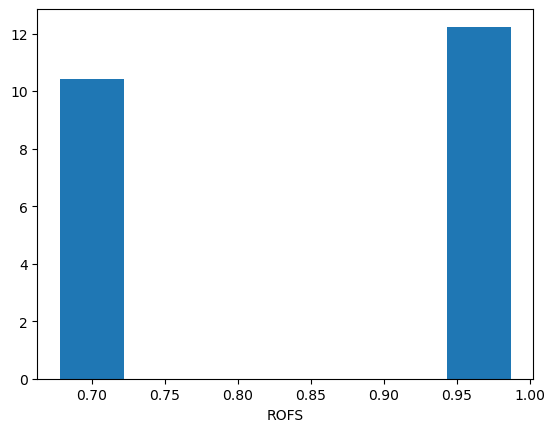

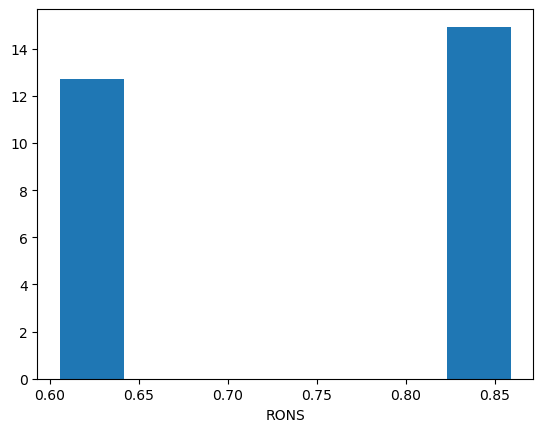

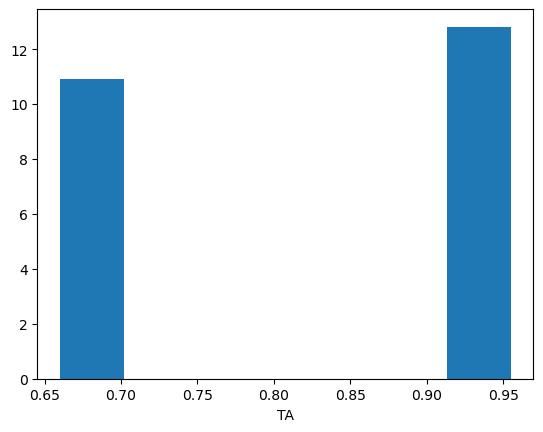

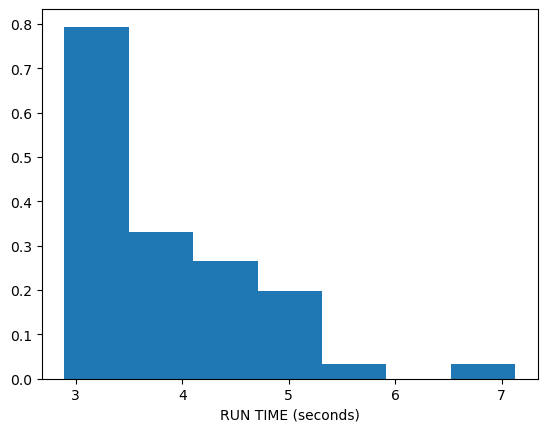

In [7]:
nn_bins = int(np.sqrt(n_trials))
# nn_bins = n_trials

plt.figure(1)
plt.hist(rofs, bins=nn_bins, density=True)
plt.xlabel('ROFS')

plt.figure(2)
plt.hist(rons, bins=nn_bins, density=True)
plt.xlabel('RONS')

plt.figure(3)
plt.hist(ta, bins=nn_bins, density=True)
plt.xlabel('TA')

plt.figure(4)
plt.hist(iteration_times, bins=nn_bins, density=True)
plt.xlabel('RUN TIME (seconds)')

plt.show()

### (normalized) histograms

In [79]:
#formulas from the theory
theo_mean_bull = (gbm_par[0][0] - (gbm_par[0][1]**2)/2)*dt
theo_mean_bear = (gbm_par[1][0] - (gbm_par[1][1]**2)/2)*dt

theo_variance_bull = (gbm_par[0][1]**2)*dt
theo_variance_bear = (gbm_par[1][1]**2)*dt

theo_std_bull = np.sqrt(theo_variance_bull)
theo_std_bear = np.sqrt(theo_variance_bear)

# print values
print(f"mean bull = {theo_mean_bull}")
print(f"variance bull = {theo_variance_bull}")

print(f"\nmean centroid 0 = {centroids[off_regime_index][0]}")
print(f"variance centroid 0 = {centroids[off_regime_index][1] - (centroids[off_regime_index][0])**2}")


print(f"\nmean bear = {theo_mean_bear}")
print(f"variance bear = {theo_variance_bear}")

print(f"\nmean centroid 1 = {centroids[on_regime_index][0]}")
print(f"variance centroid 1 = {centroids[on_regime_index][1] - (centroids[on_regime_index][0])**2}")

mean bull = -1.9668066621052235e-21
variance bull = 2.267573696145125e-05

mean centroid 0 = 3.1446875442634194e-05
variance centroid 0 = 2.3414790873846044e-05

mean bear = -3.684807256235828e-05
variance bear = 5.102040816326531e-05

mean centroid 1 = -5.599302168867773e-05
variance centroid 1 = 5.3937245599396115e-05


### (normalized) histogram of the mean

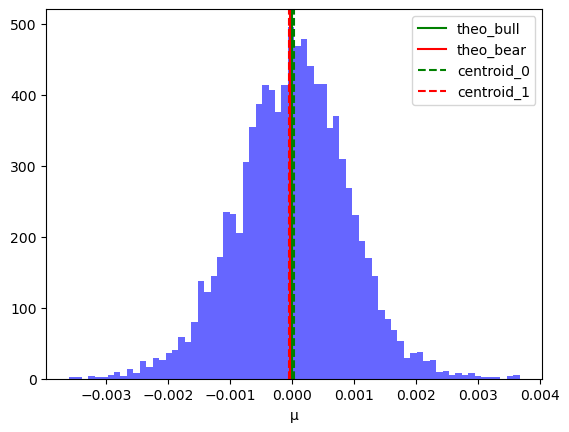

In [87]:
# Generate some sample data
data = np.mean(lift_matrix, axis=1)
n_bins = int(np.sqrt(M))
# Create the histogram
plt.hist(data, bins=n_bins, alpha=0.6, color='b', density=True) 

# Add vertical lines
plt.axvline(x=theo_mean_bull, color='green', linestyle='-', label='theo_bull')
plt.axvline(x=theo_mean_bear, color='red', linestyle='-', label='theo_bear')
plt.axvline(x=centroids[off_regime_index][0], color='green', linestyle='--', label='centroid_0')
plt.axvline(x=centroids[on_regime_index][0], color='red', linestyle='--', label='centroid_1')

# Add labels and legend
# plt.title('Distribution')
plt.xlabel('μ')
# plt.ylabel('f(x)')
plt.legend()

# Show the plot
plt.show()

### (normalized) histogram of the std

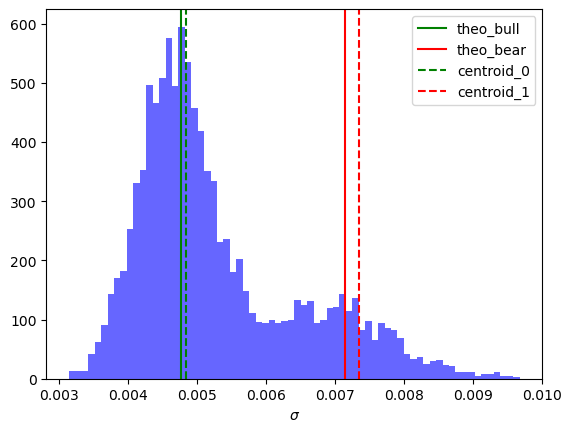

In [86]:
# Generate some sample data
data = np.std(lift_matrix, axis=1)
n_bins = int(np.sqrt(M))
# Create the histogram
plt.hist(data, bins=n_bins, alpha=0.6, color='b', density=True)  

# Add vertical lines
plt.axvline(x=theo_std_bull, color='green', linestyle='-', label='theo_bull')
plt.axvline(x=theo_std_bear, color='red', linestyle='-', label='theo_bear')
plt.axvline(x=np.sqrt(centroids[off_regime_index][1] - (centroids[off_regime_index][0])**2), color='green', linestyle='--', label='centroid_0')
plt.axvline(x=np.sqrt(centroids[on_regime_index][1] - (centroids[on_regime_index][0])**2), color='red', linestyle='--', label='centroid_1')

# Add labels and legend
plt.xlabel(f'$\sigma$')
# plt.ylabel('f(x)')
plt.legend()

# Show the plot
plt.show()